In [8]:
import numpy as np
from scipy.signal import convolve2d 
from os import path, getcwd, system, getenv
from astropy.io import fits
from time import perf_counter
import urllib.request

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import glob


from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import sys,inspect
currentdir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = path.dirname(currentdir)
sys.path.append(parentdir)
# from deconv import cube_deconv
# from ppxf_wrap import ppxf_wrap

# import warnings

# if True:
#     print('Set warnings.filterwarnings as "ignore"')
#     print('Warning Message will not be printed')
#     warnings.filterwarnings("ignore")

from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import constants
import pandas as pd

import plotly.express as px

In [9]:
def photon_energy_erg(wave_ang=1035): # lambda in Angstrom
    return constants.h/1e-7*constants.c/(wave_ang*1e-10)  # ergs

In [10]:
def set_rcparams_prop(amp=1):
    fs=18
    fs=22
    tickmajorwidth=2.5
    tickminorwidth=2.5
    axeslw=2.5
    tmjs=6*amp
    tmns=tmjs/3.5*2*amp
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [11]:
def forprint(*args, textout=1, fmt=[]):
    
    nargs=len(args)
    ncomp=len(args[0])
    
    if (len(fmt)==0) | (len(fmt) !=nargs):
        fmt=np.repeat('%s',nargs)
        
    if textout == 1:
        for i in range(ncomp):
            pstr=''
#             for arg in args:
            for j in range(nargs):
#                 pstr=pstr+str(arg[i])+' '
                pstr=pstr+(fmt[j] % (args[j])[i])+' '
            print(pstr)
        
    if type(textout) == str:
        file = open(textout,'w')
#         file.write()
        for i in range(ncomp):
            pstr=''
            for j in range(nargs):
#                 pstr=pstr+str(arg[i])+' '
                pstr=pstr+(fmt[j] % (args[j])[i])+' '
#             for arg in args:
#                 pstr=pstr+str(arg[i])+' '
            file.write(pstr+'\n')
        file.close()

In [12]:
def read_fuse(data, fmt=0):
#     temp=[x,y,z for x,y,z in data]
    if fmt==0:
        temp=np.array([[x,y,z] for x,y,z in data])
    if fmt==1:
        temp=np.array([[a,b,c,d,e,f,g] for a,b,c,d,e,f,g in data])
    return temp

In [6]:
obs_ids=np.array([
    'b1140101', 'b1140201', 'b1140301', 
    'c0570101', 'c0570201',
 'c0570202', 'c0570301', 
    'c0570401', 'p1340101', 'p1340201'
])

In [66]:
# copy raw files
data_dir='/home/hchung/fuse_data'
sub_dir='/cadc'
# for i in [8]:
for i in range(len(obs_ids)):
    obs_id=obs_ids[i]
# file_path=glob.glob(file_dir+'p134010100000all4ttagfcal.fit.gz')
# file_path=glob.glob(file_dir+'p13401010*1alif4ttagfcal.fit.gz')
    raw_file_path=np.array(glob.glob(data_dir+sub_dir+'/'+obs_id+'*1attagfraw.fit'))
    obs_dir=data_dir+'/'+obs_id
    mkdir_cmd='mkdir -p '+obs_dir
    cp_cmd='cp -f '+data_dir+sub_dir+'/'+obs_id+'*1attagfraw.fit'+' '+obs_dir+'/.'
    print(mkdir_cmd)
    print(cp_cmd)
    system(mkdir_cmd)
    system(cp_cmd)

mkdir -p /home/hchung/fuse_data/b1140101
cp -f /home/hchung/fuse_data/cadc/b1140101*1attagfraw.fit /home/hchung/fuse_data/b1140101/.
mkdir -p /home/hchung/fuse_data/b1140201
cp -f /home/hchung/fuse_data/cadc/b1140201*1attagfraw.fit /home/hchung/fuse_data/b1140201/.
mkdir -p /home/hchung/fuse_data/b1140301
cp -f /home/hchung/fuse_data/cadc/b1140301*1attagfraw.fit /home/hchung/fuse_data/b1140301/.
mkdir -p /home/hchung/fuse_data/c0570101
cp -f /home/hchung/fuse_data/cadc/c0570101*1attagfraw.fit /home/hchung/fuse_data/c0570101/.
mkdir -p /home/hchung/fuse_data/c0570201
cp -f /home/hchung/fuse_data/cadc/c0570201*1attagfraw.fit /home/hchung/fuse_data/c0570201/.
mkdir -p /home/hchung/fuse_data/c0570202
cp -f /home/hchung/fuse_data/cadc/c0570202*1attagfraw.fit /home/hchung/fuse_data/c0570202/.
mkdir -p /home/hchung/fuse_data/c0570301
cp -f /home/hchung/fuse_data/cadc/c0570301*1attagfraw.fit /home/hchung/fuse_data/c0570301/.
mkdir -p /home/hchung/fuse_data/c0570401
cp -f /home/hchung/fuse_data

In [70]:
# reduce each raw files
master_calfuse_cmds=[]
# for i in [8]:
for i in range(len(obs_ids)):
    obs_id=obs_ids[i]
    raw_dir=data_dir+'/'+obs_id+'/'
    raw_files=np.array(glob.glob(raw_dir+'*1attagfraw.fit'))
    raw_files=np.sort(raw_files)
    print(raw_files)
    calfuse_cmds=[]
    for j in range(len(raw_files)):
#     for j in range(1):
        calfuse_cmd='calfuse '+raw_files[j]
        print(calfuse_cmd)
        calfuse_cmds.append(calfuse_cmd)
        
        
    sh_file=raw_dir+'calfuse_'+obs_id+'.sh'
    forprint(calfuse_cmds, textout=sh_file)
    cd_cmd='cd '+raw_dir
    print(sh_file)
    master_calfuse_cmds.append(cd_cmd)
    master_calfuse_cmds.append('sh '+sh_file)
    
master_sh_file=data_dir+'/master_calfuse.sh'
forprint(master_calfuse_cmds, textout=master_sh_file)
# master not working

['/home/hchung/fuse_data/b1140101/b11401010011attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010021attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010031attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010041attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010051attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010061attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010071attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010081attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010091attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010101attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010111attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010121attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010131attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010141attagfraw.fit'
 '/home/hchung/fuse_data/b1140101/b11401010151attagfraw.fit']
calfuse /home/hchung/fuse_data/b1140101/b11401010011attagfraw.fit
calfuse /home/hchu

In [73]:
# idf combine / bpm_combine / extract spectra
master_comb_cmds=[]
# for i in [8]:
for i in range(len(obs_ids)):
    obs_id=obs_ids[i]
    idf_dir=data_dir+'/'+obs_id+'/'
    idf_files=np.array(glob.glob(idf_dir+'*1attagfidf.fit'))
    bpm_files=np.array(glob.glob(idf_dir+'*1attagfbpm.fit'))
    idf_files=np.sort(idf_files)
#     print(idf_files)
    idf_combined=idf_dir+obs_id+'0000attagfidf.fit'
    bpm_combined=idf_dir+obs_id+'0000attagfbpm.fit'
    
    idf_files_space=' '.join(idf_files)
    bpm_files_space=' '.join(bpm_files)
    
    comb_cmds=[]
    
    comb_cmds.append('idf_combine '+idf_combined+' '+idf_files_space)
    comb_cmds.append('bpm_combine '+bpm_combined+' '+idf_combined)
    comb_cmds.append('cf_extract_spectra '+idf_combined)
        
    sh_file=idf_dir+'idf_bpm_combine_extract_spectra_'+obs_id+'.sh'
    forprint(comb_cmds, textout=sh_file)
    
    cd_cmd='cd '+idf_dir
    master_comb_cmds.append(cd_cmd)
    master_comb_cmds.append('sh '+sh_file)
#     print(sh_file)
#     master_calfuse_cmds.append('sh '+sh_file)
    
master_comb_sh_file=data_dir+'/master_combine.sh'
print(master_sh_file)
forprint(master_comb_cmds, textout=master_comb_sh_file)

/home/hchung/fuse_data/master_combine.sh


In [75]:
#change output file name to lower case
# for i in [8]:
for i in range(len(obs_ids)):
    obs_id=obs_ids[i]
    obs_id_upper=obs_id.upper()
    print(obs_id, obs_id_upper)
    res_dir=data_dir+'/'+obs_id+'/'
    res_files=np.array(glob.glob(res_dir+obs_id_upper+'*ttagfcal.fit'))
    lower_cmds=[]
    for j in range(len(res_files)):
        mv_cmd='mv '+res_files[j]+' '+(res_files[j]).lower()
        print(mv_cmd)
        system(mv_cmd)

b1140101 B1140101
mv /home/hchung/fuse_data/b1140101/B11401010091alif4ttagfcal.fit /home/hchung/fuse_data/b1140101/b11401010091alif4ttagfcal.fit
mv /home/hchung/fuse_data/b1140101/B11401019991asic4ttagfcal.fit /home/hchung/fuse_data/b1140101/b11401019991asic4ttagfcal.fit
mv /home/hchung/fuse_data/b1140101/B11401010141alif4ttagfcal.fit /home/hchung/fuse_data/b1140101/b11401010141alif4ttagfcal.fit
mv /home/hchung/fuse_data/b1140101/B11401010121asic4ttagfcal.fit /home/hchung/fuse_data/b1140101/b11401010121asic4ttagfcal.fit
mv /home/hchung/fuse_data/b1140101/B11401010111alif4ttagfcal.fit /home/hchung/fuse_data/b1140101/b11401010111alif4ttagfcal.fit
mv /home/hchung/fuse_data/b1140101/B11401010151asic4ttagfcal.fit /home/hchung/fuse_data/b1140101/b11401010151asic4ttagfcal.fit
mv /home/hchung/fuse_data/b1140101/B11401010031alif4ttagfcal.fit /home/hchung/fuse_data/b1140101/b11401010031alif4ttagfcal.fit
mv /home/hchung/fuse_data/b1140101/B11401010061alif4ttagfcal.fit /home/hchung/fuse_data/b1140

In [7]:
# thdu=fits.open('/home/hchung/fuse_data/p1340101/p13401010000attagfidf.fit')
thdu=fits.open('/home/hchung/fuse_data/p1340101/p13401019991alif4ttagfcal.fit')
# thdu=fits.open('/home/hchung/fuse_data/p1340101/p13401010011alif4ttagfcal.fit')
thdu.info()
thdu[0].header

Filename: /home/hchung/fuse_data/p1340101/p13401019991alif4ttagfcal.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     401   ()      
  1  SPECTRUM      1 BinTableHDU     35   7694R x 7C   [1E, 1E, 1E, 1J, 1E, 1E, 1I]   


SIMPLE  =                    T / Data conforms to FITS standard                 
BITPIX  =                   16 / Bits per data value                            
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / File may contain standard extensions           
NEXTEND =                    1 / Number of standard extensions                  
GROUPS  =                    F / Image is in group format                       
DATE    = '2021-01-31T16:31:20' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
                                                                                
              DATA DESCRIPTION KEYWORDS                                         
                                                                                
TELESCOP= 'FUSE              ' / Telescope used to acquire data                 
INSTRUME= 'FUV               ' / Instrument in use (one of FUV, FESA, or FESB)  
ROOTNAME= 'P1340101999'     

In [13]:
rawfile='/home/hchung/fuse_data/b1140101/b11401010011attagfraw.fit'
rhdu=fits.open(rawfile)
rhdu[0].header

SIMPLE  =                    T / Data conforms to FITS standard                 
BITPIX  =                   16 / Bits per data value                            
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / File may contain standard extensions           
NEXTEND =                    2 / Number of standard extensions                  
GROUPS  =                    F / Image is in group format                       
DATE    = '2007-11-08        ' / Date this file was written (yyyy-mm-dd)        
                                                                                
              DATA DESCRIPTION KEYWORDS                                         
                                                                                
TELESCOP= 'FUSE              ' / Telescope used to acquire data                 
INSTRUME= 'FUV               ' / Instrument in use (one of FUV, FESA, or FESB)  
ROOTNAME= 'B1140101001      

Filename: /home/hchung/fuse_data/p1340101/p13401019991alif4ttagfcal.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     401   ()      
  1  SPECTRUM      1 BinTableHDU     35   7694R x 7C   [1E, 1E, 1E, 1J, 1E, 1E, 1I]   


(0, 10)

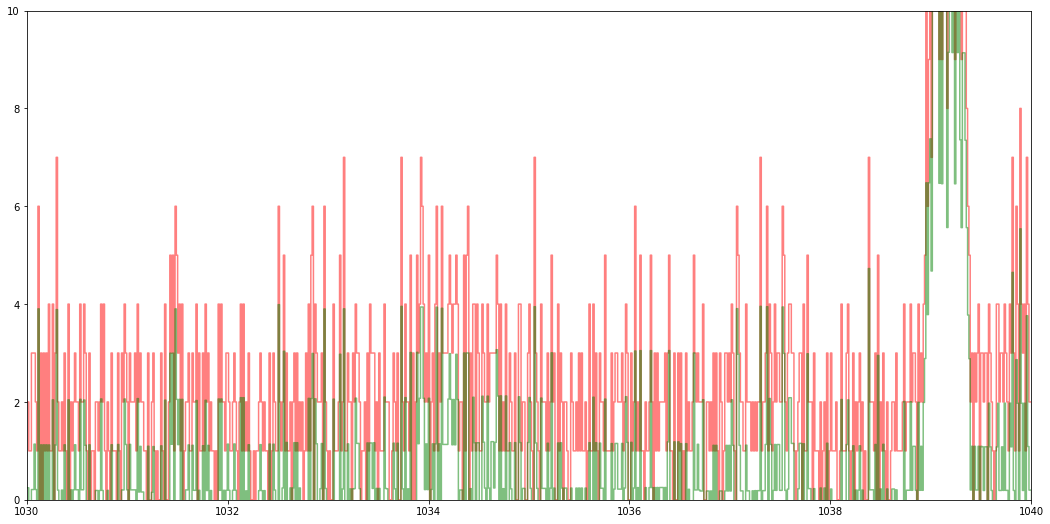

In [65]:
# thdu=fits.open('/home/hchung/fuse_data/test/B11403010021alif4ttagfcal.fit')
# thdu=fits.open('/home/hchung/fuse_data/b114030100000all4ttagfcal.fit')
thdu=fits.open('/home/hchung/fuse_data/p1340101/p13401019991alif4ttagfcal.fit')
# fits_hdu[0].header
thdu.info()
# thdu[1].header
thdu[0].header
# thdu['SPECTRUM']
specd=thdu['SPECTRUM'].data
expt=thdu[0].header['EXPTIME']
# exptn=eptn+thdu[0].header['EXPNIGHT']
res=read_fuse(specd, fmt=1)
tcnt_idx=3
wave=res[:,0]
tflx=res[:,1]
tcnt=res[:,tcnt_idx]
# wcnt=res[:,]
bkct=res[:,5]
# 'ERG CM^-2 S^-1 ANG^-1' / physic
perg=photon_energy_erg(wave_ang=wave)
effarea=25
tcnt_ff=tflx*effarea/perg*expt*(wave[1]-wave[0])


thdu2=fits.open('/home/hchung/fuse/MAST_2020-07-20T2021/FUSE/b1140301000/b11403010021alif4ttagfcal.fit.gz')
# thdu2=fits.open('/home/hchung/fuse/MAST_2020-07-20T2021/FUSE/b1140301000/b11403010051alif4ttagfcal.fit.gz')
specd2=thdu2['SPECTRUM'].data
expt2=expt+thdu2[0].header['EXPTIME']
# exptn2=exptn+thdu2[0].header['EXPNIGHT']
res2=read_fuse(specd2, fmt=1)
wave2=res2[:,0]
tflx2=res2[:,1]
tcnt2=res2[:,tcnt_idx]
perg2=photon_energy_erg(wave_ang=wave2)
effarea=27
tcnt_ff2=tflx2*effarea/perg2*expt2*(wave2[1]-wave2[0])


fig=plt.figure(figsize=(18,9))
ax=fig.add_subplot(111)


ax.step(wave, tcnt, 'r', where='mid', zorder=0.5, alpha=0.5)
ax.step(wave, tcnt_ff, 'g', where='mid', zorder=0.5, alpha=0.5)
# ax.step(wave, tflx, 'r', where='mid', zorder=0.5, alpha=0.5)

# ax.step(wave2, tcnt2, 'b', where='mid', zorder=0.5, alpha=0.5)
# ax.step(wave2, tcnt_ff2/2, 'k', where='mid', zorder=0.5, alpha=0.5)


# ax.step(wave2, tcnt-tcnt2, 'b', where='mid', zorder=0.5, alpha=0.5)

# ax.set_ylim()
ax.set_xlim([1020,1050])
# ax.set_xlim([1025,1030])
ax.set_xlim([1030,1040])
ax.set_ylim([0,10])
# hdu[1].header

# thdu[0].header
# thdu2[0].header

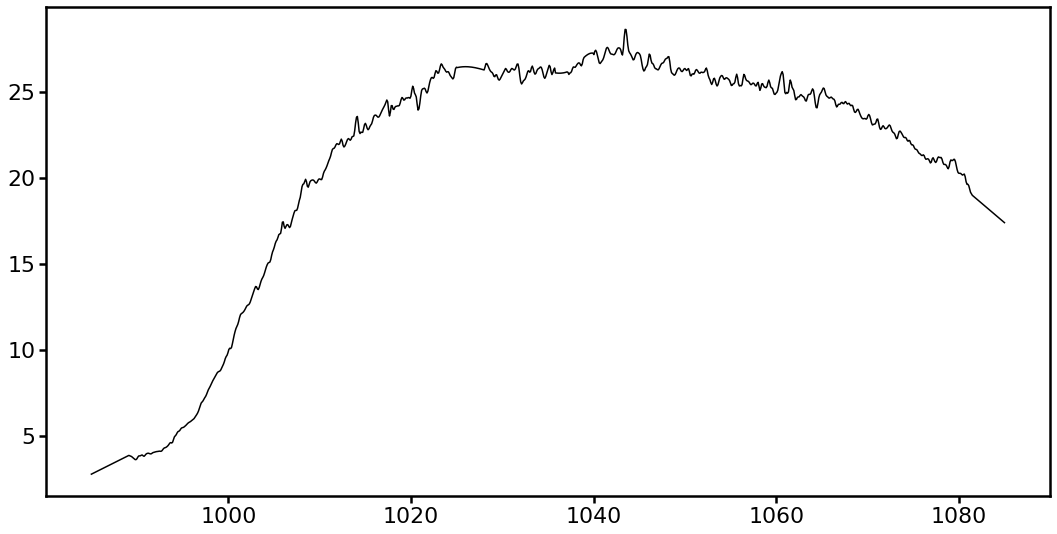

In [458]:
effhdu=fits.open('/home/hchung/calfuse/v3.2/calfiles/aeff1a104.fit')
effhdu[3].header

effdata=effhdu[3].data
fig=plt.figure(figsize=(18,9))
ax=fig.add_subplot(111)
# effwave=effdata['wave']
# effarea=effdata['area']
effres=np.array([[a,b] for a,b in effdata])
effres.shape
effwave=effres[0,0,:]
effarea=effres[0,1,:]
ax.plot(effwave,effarea, 'k-')